In [1]:

import pandas as pd
from pathlib import Path
import warnings
import pandas as pd
import os
warnings.filterwarnings("ignore")


In [2]:
folder_path = "Binance_volumn_change"
number_bucket = 65
V = 262
os.makedirs(folder_path, exist_ok=True)
file_name = f"{folder_path}/{number_bucket}_bucket_{V}"


In [3]:
symbol = "BTCUSDT"
if Path("Users").exists():  # Windows
    input_path = r"C:\Users\phamhoa\Downloads\thesis\data\Binance\agg\500\VPIN"
    file_path = rf"{input_path}\{symbol}.csv"
else:  # Macbook
    input_path = "/Users/hoapham/Documents/Learning/thesis/data/Binance/agg/500/VPIN"
    file_path = f"{input_path}/{symbol}_{number_bucket}.csv"

data = pd.read_csv(file_path, parse_dates=['Time'])

data = data.drop(columns=["Unnamed: 0"], errors='ignore')
data.drop("KyleLambda", axis=1, inplace=True, errors='ignore')


=== KẾT QUẢ FLASH CRASH ===
Start : 2025-10-10 21:15:12+00:00, Price = 112126.44
Trough: 2025-10-10 21:20:10+00:00, Price = 103406.81
End   : 2025-10-10 21:31:23+00:00,   Price = 109122.86


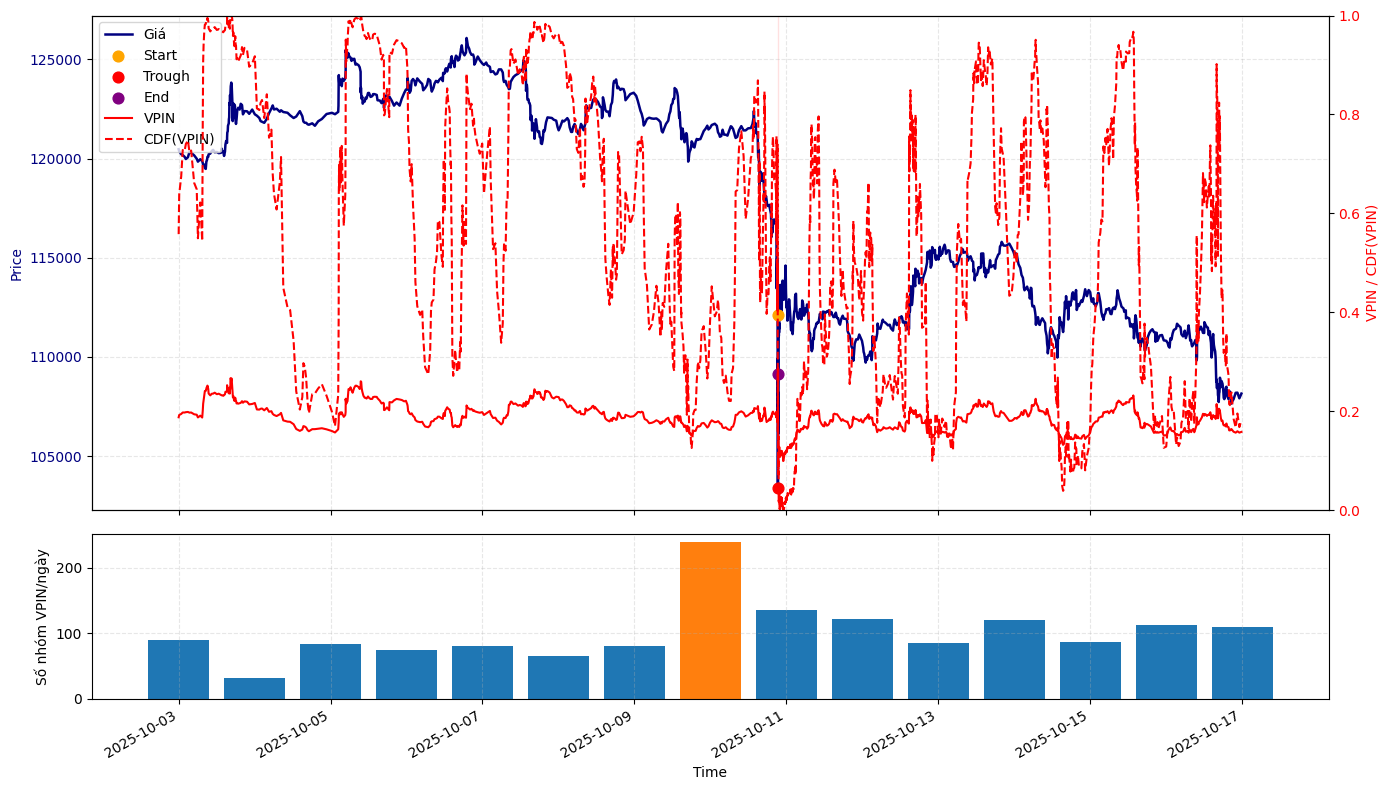

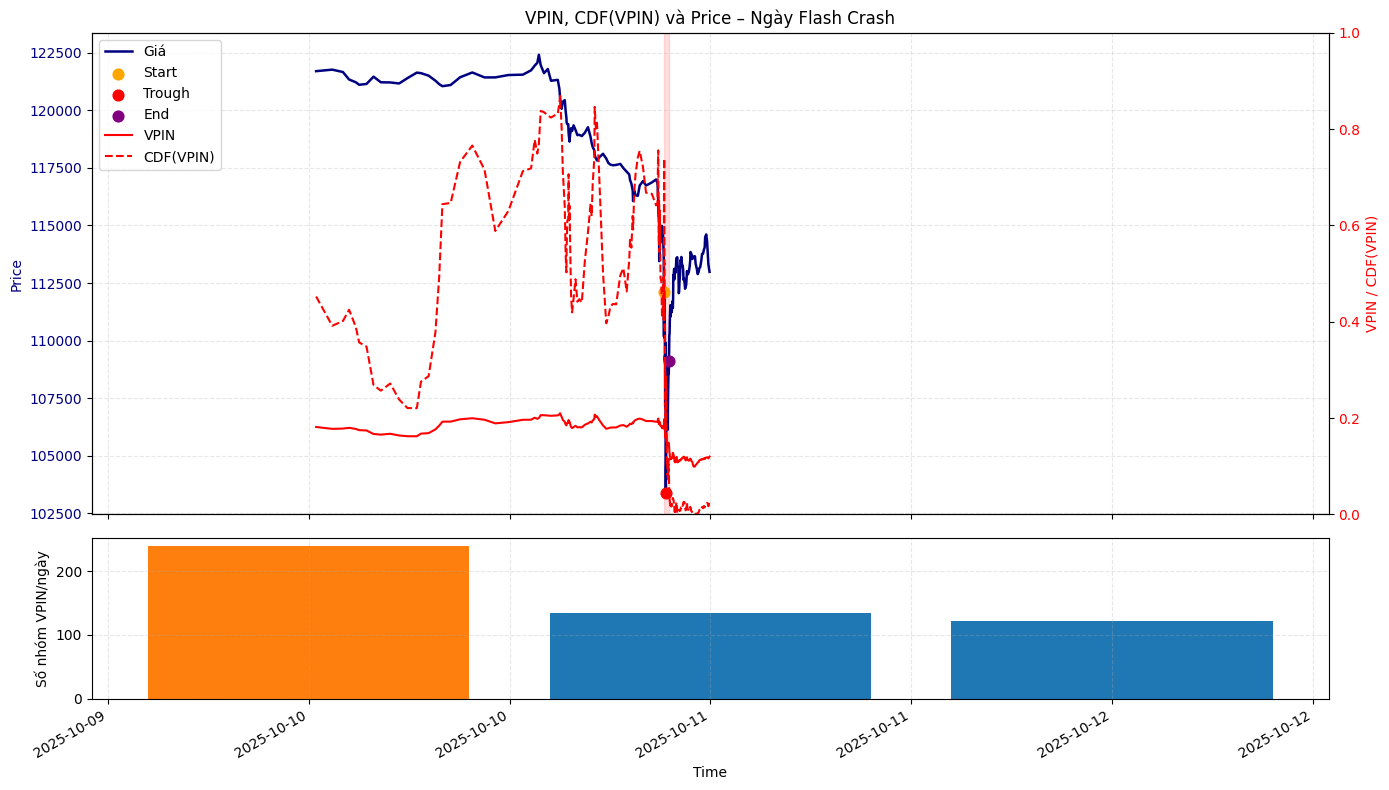

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ======================================================
# 0. CHUẨN BỊ DỮ LIỆU
# ======================================================
df = data.copy()
df["Time"] = pd.to_datetime(df["Time"])
df = df.sort_values("Time").set_index("Time")

# ======================================================
# 1. PHÁT HIỆN FLASH CRASH (code của bạn, giữ nguyên logic)
# ======================================================
look_ahead = 3                   # 3 nhóm kế tiếp
pre_window = pd.Timedelta("5T")  # 5 phút liền trước
pre_trend_tol = -0.01            # 5 phút trước không được rơi quá 1%

trough_left_span  = 10
trough_right_span = 10
start_left_span   = 20
end_right_span    = 20

# 1.1 dd_m(t)
fut = pd.concat([df["Price"].shift(-k) for k in range(1, look_ahead + 1)], axis=1)
fwd_min = fut.min(axis=1)
df["dd_m"] = (fwd_min / df["Price"]) - 1

# 1.2 Ngưỡng mean - 3σ
mu = df["dd_m"].mean()
sigma = df["dd_m"].std()
threshold = mu - 3 * sigma

candidates = df[df["dd_m"] < threshold].copy()

start = trough = end = None

if len(candidates) > 0:
    # 1.3 Filter 5 phút trước không rơi quá mạnh
    valid_idx = []
    for t in candidates.index:
        t0 = t - pre_window
        hist = df["Price"].loc[t0:t]
        if len(hist) == 0:
            continue
        p_past = hist.iloc[0]
        p_now = df.loc[t, "Price"]
        pre_ret = p_now / p_past - 1.0
        if pre_ret >= pre_trend_tol:
            valid_idx.append(t)

    if len(valid_idx) > 0:
        valid_candidates = candidates.loc[valid_idx]
        anchor = valid_candidates["dd_m"].idxmin()
        anchor_pos = df.index.get_loc(anchor)

        # 1.4 Tìm đáy
        left_bound  = max(0, anchor_pos - trough_left_span)
        right_bound = min(len(df) - 1, anchor_pos + trough_right_span)
        local_segment = df["Price"].iloc[left_bound:right_bound + 1]
        trough = local_segment.idxmin()
        trough_pos = df.index.get_loc(trough)

        # 1.5 Tìm start (đỉnh trước khi rơi)
        left_start_bound = max(0, trough_pos - start_left_span)
        left_segment = df["Price"].iloc[left_start_bound:trough_pos]
        start = left_segment.idxmax() if len(left_segment) > 0 else trough

        # 1.6 Tìm end (đỉnh sau khi bật)
        right_end_bound = min(len(df) - 1, trough_pos + end_right_span)
        right_segment = df["Price"].iloc[trough_pos+1:right_end_bound+1]
        end = right_segment.idxmax() if len(right_segment) > 0 else trough

        if not (start < trough < end):
            print("Cảnh báo: thứ tự start–trough–end không chuẩn.")
    else:
        print("Không còn ứng viên sau filter 5 phút trước.")
else:
    print("Không tìm thấy ứng viên dd_m < mean-3σ.")

print("\n=== KẾT QUẢ FLASH CRASH ===")
if start is None or trough is None or end is None:
    print("Không phát hiện flash crash.")
else:
    print(f"Start : {start}, Price = {df.loc[start, 'Price']:.2f}")
    print(f"Trough: {trough}, Price = {df.loc[trough, 'Price']:.2f}")
    print(f"End   : {end},   Price = {df.loc[end, 'Price']:.2f}")

# Nếu không tìm được flash crash thì dừng
if start is None or trough is None or end is None:
    raise RuntimeError("Không xác định được flash crash, không thể vẽ.")

# Ngày flash crash (dùng đáy làm anchor)
flash_crash_date = trough.normalize()

# ======================================================
# 2. HÀM VẼ: 2 SUBPLOT (PRICE+VPIN+CDF / SỐ NHÓM VPIN MỖI NGÀY)
# ======================================================

def plot_vpin_price_and_bucket_counts(df, start_time, end_time,
                                      start_fc, trough_fc, end_fc,
                                      flash_crash_date,
                                      days,
                                      title="",):
    """
    df: DataFrame index = Time, có cột Price, VPIN, CDF
    start_time, end_time: khoảng thời gian để vẽ (Timestamp)
    start_fc, trough_fc, end_fc: 3 mốc flash crash (Timestamp)
    flash_crash_date: ngày chứa flash crash (Timestamp.normalize())
    """

    # Cắt window
    df_win = df.loc[start_time:end_time].copy()

    # Chuẩn bị daily counts VPIN
    daily_counts_all = df["VPIN"].resample("D").count()
    # Lấy phần ngày nằm trong [start_time, end_time]
    day_start = start_time.normalize()
    day_end = (end_time + pd.Timedelta(days=1)).normalize()
    daily_counts = daily_counts_all.loc[day_start:day_end]

    # Colors: tô cam cho ngày có flash crash
    colors = [
        "tab:orange" if d.normalize() == flash_crash_date else "tab:blue"
        for d in daily_counts.index
    ]

    fig, (ax_top, ax_bot) = plt.subplots(
        2, 1, figsize=(14, 8), sharex=True,
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # ---------------- TOP: PRICE (trục trái) + VPIN, CDF (trục phải) ----------------
    # Price – trục trái
    ax_price = ax_top
    ax_price.plot(df_win.index, df_win["Price"],
                  color="navy", linewidth=1.8, label="Giá")
    ax_price.set_ylabel("Price", color="navy")
    ax_price.tick_params(axis="y", labelcolor="navy")
    ax_price.grid(True, linestyle="--", alpha=0.3)

    # VPIN & CDF – trục phải
    ax_vpin = ax_price.twinx()
    ax_vpin.plot(df_win.index, df_win["VPIN"],
                 color="red", linewidth=1.5, label="VPIN")
    ax_vpin.plot(df_win.index, df_win["CDF"],
                 color="red", linestyle="--", linewidth=1.5, label="CDF(VPIN)")
    ax_vpin.set_ylabel("VPIN / CDF(VPIN)", color="red")
    ax_vpin.tick_params(axis="y", labelcolor="red")
    ax_vpin.set_ylim(0, max(1, df_win["VPIN"].max()*1.1))

    # Đánh dấu 3 điểm flash crash trên đường giá
    ax_price.scatter(start_fc, df.loc[start_fc, "Price"],
                     color="orange", s=60, zorder=5, label="Start")
    ax_price.scatter(trough_fc, df.loc[trough_fc, "Price"],
                     color="red", s=60, zorder=5, label="Trough")
    ax_price.scatter(end_fc, df.loc[end_fc, "Price"],
                     color="purple", s=60, zorder=5, label="End")

    # Có thể tô background vùng crash nếu muốn
    ax_price.axvspan(start_fc, end_fc, color="red", alpha=0.12)

    # Legend gộp cả 2 trục
    lines1, labels1 = ax_price.get_legend_handles_labels()
    lines2, labels2 = ax_vpin.get_legend_handles_labels()
    ax_top.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    ax_top.set_title(title)

    # ---------------- BOTTOM: SỐ NHÓM VPIN MỖI NGÀY ----------------
    ax_bot.bar(daily_counts.index, daily_counts.values,
               color=colors, width=0.8)
    ax_bot.set_ylabel("Số nhóm VPIN/ngày")
    ax_bot.grid(True, linestyle="--", alpha=0.3)

    # Format trục thời gian
    ax_bot.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax_bot.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax_bot.get_xticklabels(), rotation=30, ha="right")

    ax_bot.set_xlabel("Time")

    plt.tight_layout()
    plt.savefig(f"{file_name}_{days}.png", dpi=200)
    
    plt.show()
    plt.close(fig)
# ======================================================
# 3. VẼ 2 BIỂU ĐỒ:
#    (1) 1 TUẦN TRƯỚC & SAU NGÀY FLASH CRASH
#    (2) RIÊNG NGÀY FLASH CRASH
# ======================================================

# (1) 1 tuần trước & sau
week_start = flash_crash_date - pd.Timedelta(days=7)
week_end   = flash_crash_date + pd.Timedelta(days=7)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=week_start,
    end_time=week_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    days = 14
    # title="VPIN, CDF(VPIN) và Price – 1 tuần trước & sau Flash Crash"
)

# (2) Ngày flash crash
day_start = flash_crash_date
day_end   = flash_crash_date + pd.Timedelta(days=1)

plot_vpin_price_and_bucket_counts(
    df,
    start_time=day_start,
    end_time=day_end,
    start_fc=start,
    trough_fc=trough,
    end_fc=end,
    flash_crash_date=flash_crash_date,
    title="VPIN, CDF(VPIN) và Price – Ngày Flash Crash",
    days = 3
)
